We import `netgen.gui` to open the netgen GUI for displaying the ferromagnet. 
We then define the geometry, and draw the box. 
The refinement of the mesh is controlled by `H_MAX` in `ngmesh`.
The maximum time for the simulation is given by `T_MAX`, and has time step `K`.
Use `THETA` to determine "how implicit the tangent plane scheme solver is". Closer to 1/2 is usually better, but must be above 1/2 for unconditional convergence.

In [11]:
from netgen.csg import *
from ngsolve import *
from ngsolve.utils import (
    Grad
)  # If I don't import these explicitly, VSCode reads them as missing.
import netgen.gui  # this opens up the netgen ui
import Magnetisation_Functions as magfunc
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import Elastic_Functions as elfunc
import General_Functions as genfunc
import sys
import time
np.set_printoptions(threshold=sys.maxsize)


# MATERIAL PARAMETERS
M_s = 1.5e6
gyromagnetic_ratio = 1.761e11
exchange_length = 3e-9
lambda_m: float = 30e-6  # saturation magnetostrain parameter
mu_0 = 1.25663706e-6
density = 7900
KAPPA: float = genfunc.calculate_KAPPA(density, exchange_length, gyromagnetic_ratio, mu_0)  # Determines the relative strength of the elastic vs. magnetic parts.
stress_fac = genfunc.stress_density_factor(KAPPA=KAPPA, mu_0=mu_0, M_s=M_s)
mu, lam = 54e9/stress_fac, 172e9/stress_fac
ALPHA: float = 0.005  # Dissipative constant in the LLG equation.

# SIMULATION PARAMETERS
T_MAX_DIM: float = 1e-7  # The maximum time for the simulation in seconds
THETA: float = 0.50000005  # Should be strictly above 1/2 for unconditional stability, but close to 1/2 to reduce (artificial) numerical dissipation
time_step_dim = 1e-10 # seconds
K: float = time_step_dim*genfunc.nondimensional_time(gyromagnetic_ratio, mu_0, M_s=M_s)  # TIME STEP
T_MAX: float = T_MAX_DIM*genfunc.nondimensional_time(gyromagnetic_ratio, mu_0, M_s=M_s)
H_MAX: float = 0.3  # Determines how fine the mesh should be.

print(f"µ = {mu}, λ = {lam}, κ = {KAPPA}")
print(f"K = {K}, T_MAX = {T_MAX}")

µ = 6.89291942771162, λ = 21.955224843822197, κ = 2770.7553226385685
K = 33.1940679399, T_MAX = 33194.0679399


$\boldsymbol\sigma_{ij} = 2\mu \boldsymbol\varepsilon_{ij}^{\text{el}} + \lambda \delta_{ij}\boldsymbol\varepsilon_{kk}^{\text{el}}$ Hooke's Law

$\mathbb{Z}_{ijkl} \boldsymbol E_{kl} = \frac{3\lambda_{s}}{2}\left(\boldsymbol E_{ij} - \frac{1}{3}\delta_{ij}\boldsymbol E_{kk}\right)$  Isotropic, isochoric magnetostrain for some symmetric input

Here we make a cube with labelled faces.

In [12]:
def MakeGeometry():  # this makes a box, with labelled faces
    geometry = CSGeometry()
    left = Plane(Pnt(0, 0, 0), Vec(-1, 0, 0)).bc("left")
    right = Plane(Pnt(10/3, 10/3, 10/3), Vec(1, 0, 0)).bc("right")
    front = Plane(Pnt(0, 0, 0), Vec(0, -1, 0)).bc("front")
    back = Plane(Pnt(1, 1, 1), Vec(0, 1, 0)).bc("back")
    bot = Plane(Pnt(0, 0, 0), Vec(0, 0, -1)).bc("bot")
    top = Plane(Pnt(1, 1, 1), Vec(0, 0, 1)).bc("top")

    cube = left * right * front * back * bot * top
    geometry.Add(cube)
    # cube = OrthoBrick(Pnt(0,0,0), Pnt(1,1,1))
    return geometry


ngmesh = MakeGeometry().GenerateMesh(maxh=H_MAX)
# ngmesh.Save("cube.vol")
mesh = Mesh(ngmesh)
Draw(mesh)
print(genfunc.MaximumMeshSize(mesh))

0.6084879977470037


We make two FE spaces, one for magnetisation `fes_mag`, and one for displacement/velocity `fes_disp`. (and a legacy FE space for matrices `fes_eps_m`)

The displacement has a `dirichlet` condition, in this case on the `left` face.

We then introduce `f_body`, which is a body force density. We use simply gravity here. You can also set a traction on specific faces with `g_surface`.

In [13]:
fes_mag = VectorH1(
    mesh, order=1
)  # the finite element space for the magnetisation m_h^i
fes_disp = VectorH1(
    mesh, order=1, dirichlet="left"
)  # the finite element space for the displacement u_h^i
fes_scalar = H1(mesh, order=1)
print(f"mag_ndof={fes_mag.ndof}, disp_ndof={fes_disp.ndof},\n, dispfree_ndof={fes_disp.FreeDofs()}")
mag_gfu = GridFunction(fes_mag)
disp_gfu = GridFunction(fes_disp)
prev_disp_gfu = GridFunction(fes_disp) #  used to store the previous displacement
zeeman_factor = Parameter(1e-2)
f_zeeman = CoefficientFunction((0, zeeman_factor, 0))
# body force and traction force
body_factor = Parameter(genfunc.force_density_grav(grav_accel=-9.81, density=density, exchange_length=exchange_length, KAPPA=KAPPA, mu_0=mu_0, M_s=M_s))
f_body = CoefficientFunction((0.0, 0.0, body_factor))
surface_factor = Parameter(0/stress_fac)
g_surface = CoefficientFunction([(0,surface_factor,0) if bc=="right" else (0,0,0) for bc in mesh.GetBoundaries()])
Draw(g_surface, mesh, "gsruface")
Draw(f_body, mesh, "fbody")
print(body_factor)

mag_ndof=633, disp_ndof=633,
, dispfree_ndof=0: 00001111001111111111111111111111111111111111111111
50: 11111100000011000011111111111111111111111111111111
100: 11111111111111111111111111111111111111111111111111
150: 11111111111111111111111111111111111111111111111111
200: 11111111111000011110011111111111111111111111111111
250: 11111111111111111000000110000111111111111111111111
300: 11111111111111111111111111111111111111111111111111
350: 11111111111111111111111111111111111111111111111111
400: 11111111111111111111110000111100111111111111111111
450: 11111111111111111111111111110000001100001111111111
500: 11111111111111111111111111111111111111111111111111
550: 11111111111111111111111111111111111111111111111111
600: 111111111111111111111111111111111
ParameterCF, val = -2.96775e-14



Here we give initial conditions for the magnetisation and displacement.

The magnetisation can either be given fully random, or uniform magnetisation. If you choose uniform, you must pick the direction. It will be automatically normalised.

The displacement can also be given a fully random or uniform. For the displacement, you can choose the largest magnitude for the random displacement.

In [14]:
# Initial conditions
mag_gfu = magfunc.give_uniform_magnetisation(mag_gfu, (1.0, 0.0, 0.0))
#disp_gfu = elfunc.give_random_displacement(disp_gfu)
disp_gfu = elfunc.give_uniform_displacement(disp_gfu, (0.0, 0.0, 0.0))  # initial displacement
velocity_gfu = GridFunction(fes_disp)  # velocity
# make initial conditions compatible with Dirichlet boundary conditions
disp_gfu.Set(CoefficientFunction((0,0,0)), BND)
velocity_gfu.Set(CoefficientFunction((0,0,0)), BND)
velocity_gfu = elfunc.give_uniform_displacement(velocity_gfu, (0.0, 0.0, 0.0))  # An initial velocity. Should only be used once in iteration.
Draw(mag_gfu, mesh, "magnetisation")
Draw(disp_gfu, mesh, "displacement")
proj_mag = magfunc.nodal_projection(mag_gfu, fes_mag)
strain_m = magfunc.build_strain_m(proj_mag, lambda_m)
box_vol = Integrate(CF(1.0), mesh)
current_integral = magfunc.constraint_error(fes_scalar, mag_gfu, mesh)
current_nodal_norm = magfunc.nodal_norm(mag_gfu)
print(f"_/‾|m|^2dx = {current_integral}, nodal max = {current_nodal_norm} (should both be 1)")

a=1.0,b=0.0,c=0.0, size=1.0
_/‾|m|^2dx = 5.439577907837112e-17, nodal max = 1.0 (should both be 1)


In [15]:
len(mag_gfu.vec)

633

These are lists of values to be used in plotting later, to demonstrate that the `energy` decreases over time. The `integral_list` is a list of constraint violation integrals $\int_{\Omega}|\mathcal{I}_{h}(|\mathbf{m}_{h}^{i}|^2)-1| \mathrm{d}x$, and the `nodal_sum_list` is a list of the max of nodal magnitudes $\max_{z\in\mathcal{N}_{h}}|\mathbf{m}_{h}^{i}(z)|^2$. The `nodal_sum_list` and `integral_list` should be non-decreasing if the tangent plane scheme is functioning. 

In [16]:
energy_list = np.array([magfunc.magnetic_energy(mag_gfu, mesh, f_zeeman) + elfunc.elastic_energy(mesh, disp_gfu, strain_m, f_body, g_surface, KAPPA, mu, lam)])
kin_energy_list = np.array([elfunc.initial_kinetic_energy(mesh, velocity_gfu, KAPPA)])
integral_list = np.array([magfunc.constraint_error(fes_scalar, mag_gfu, mesh)])
nodal_sum_list= np.array([magfunc.nodal_norm(mag_gfu)])
x_avg, y_avg, z_avg = magfunc.component_integrator(mag_gfu, mesh, box_vol)
x_average_list, y_average_list, z_average_list = np.array([x_avg]), np.array([y_avg]), np.array([z_avg])
x_avg_disp, y_avg_disp, z_avg_disp = magfunc.component_integrator(disp_gfu, mesh, box_vol)
x_average_disp_list, y_average_disp_list, z_average_disp_list = np.array([x_avg_disp]), np.array([y_avg_disp]), np.array([z_avg_disp])


In [17]:
genfunc.export_to_vtk_file(disp_gfu, mag_gfu, mesh, export=True, index=0)

This is the first run of the simulation, which needs to be treated differently as we have a prescribed initial velocity $\dot{\mathbf{u}}^{0}$. First compute the update $\mathbf{v}_{h}^{i}$ to get $\mathbf{m}_{h}^{i+1} = \mathbf{m}_{h}^{i} + k\mathbf{v}_{h}^{i}$ using the tangent plane scheme (with GMRES). Then using the conservation of momentum equation calculate $\mathbf{u}_{h}^{i+1}$ using the internal solver of NGSolve using the Conjugate Gradient method.

In [18]:
num_steps = genfunc.ceiling_division(T_MAX, K)  # This is ceiling division, using upside-down floor division.
#first run
M_mag_fixed, L_mag_fixed = magfunc.build_fixed_mag(fes_mag, ALPHA, THETA, K)  # static portion of the magnetisation linear system
v0 = np.zeros(fes_mag.ndof)
mag_gfu, v0 = magfunc.update_magnetisation(fes_mag, mag_gfu, ALPHA, THETA, K, KAPPA, disp_gfu, mu, lam, lambda_m, f_zeeman, M_mag_fixed, L_mag_fixed, v0)

proj_mag = magfunc.nodal_projection(mag_gfu, fes_mag)
strain_m = magfunc.build_strain_m(proj_mag, lambda_m)
new_disp = elfunc.FIRST_RUN_update_displacement(fes_disp, disp_gfu, velocity_gfu, strain_m, f_body, g_surface, K, mu, lam)
prev_disp_gfu.vec.data = disp_gfu.vec.data
disp_gfu.vec.data = new_disp.vec.data

current_integral = magfunc.constraint_error(fes_scalar, mag_gfu, mesh)
current_nodal_norm = magfunc.nodal_norm(mag_gfu)
current_energy = magfunc.magnetic_energy(mag_gfu, mesh, f_zeeman) + elfunc.elastic_energy(mesh, disp_gfu, strain_m, f_body, g_surface, KAPPA, mu, lam)
current_kinetic_energy = elfunc.kinetic_energy(mesh, disp_gfu, prev_disp_gfu, KAPPA, K)


integral_list = np.append(integral_list, current_integral)
nodal_sum_list = np.append(nodal_sum_list, current_nodal_norm)
energy_list = np.append(energy_list, current_energy)
kin_energy_list = np.append(kin_energy_list, current_kinetic_energy)
x_avg, y_avg, z_avg = magfunc.component_integrator(mag_gfu, mesh, box_vol)
x_average_list, y_average_list, z_average_list = np.append(x_average_list, x_avg), np.append(y_average_list, y_avg), np.append(z_average_list, z_avg)
x_avg_disp, y_avg_disp, z_avg_disp = magfunc.component_integrator(disp_gfu, mesh, box_vol)
x_average_disp_list, y_average_disp_list, z_average_disp_list = np.append(x_average_disp_list, x_avg_disp), np.append(y_average_disp_list, y_avg_disp), np.append(z_average_disp_list, z_avg_disp)

Q GMRES completed in 0.0044155120849609375, info=0, residual = 0.0


In [19]:
mip = mesh(0.0, 0.0, 0)
print(strain_m(mip))

(2.5533899550650746e-05, 6.727256900688603e-08, -1.345451379272019e-05, 6.727256900688603e-08, -1.4999888350279866e-05, -2.2329944012513295e-08, -1.345451379272019e-05, -2.2329944012513295e-08, -1.0534011200370885e-05)


In [20]:
# subsequence runs
print(f"num_steps={num_steps}")
real_time_count = 0
for i in range(1, num_steps):
    time_start = time.time()
    mag_gfu, v0 = magfunc.update_magnetisation(fes_mag, mag_gfu, ALPHA, THETA, K, KAPPA, disp_gfu, mu, lam, lambda_m, f_zeeman, M_mag_fixed, L_mag_fixed, v0)
    proj_mag = magfunc.nodal_projection(mag_gfu, fes_mag)
    strain_m = magfunc.build_strain_m(proj_mag, lambda_m)
    new_disp = elfunc.update_displacement(fes_disp, disp_gfu, prev_disp_gfu, strain_m, f_body, g_surface, K, mu, lam)
    prev_disp_gfu.vec.data = disp_gfu.vec.data
    disp_gfu.vec.data = new_disp.vec.data
    #Redraw()
    current_integral = magfunc.constraint_error(fes_scalar, mag_gfu, mesh)
    current_nodal_norm = magfunc.nodal_norm(mag_gfu)
    current_energy = magfunc.magnetic_energy(mag_gfu, mesh, f_zeeman) + elfunc.elastic_energy(mesh, disp_gfu, strain_m, f_body, g_surface, KAPPA, mu, lam)
    current_kinetic_energy = elfunc.kinetic_energy(mesh, disp_gfu, prev_disp_gfu, KAPPA, K)
    print(f"Step {i}:_/‾I_h(|m|^2) - 1 dx = {current_integral}, nodal max = {current_nodal_norm}")
    print(f" energy      = {current_energy},   kin. energy = {current_kinetic_energy}")
    genfunc.export_to_vtk_file(disp_gfu, mag_gfu, mesh, export=True, index=i, save_step=10)
    integral_list = np.append(integral_list, current_integral)
    nodal_sum_list = np.append(nodal_sum_list, current_nodal_norm)
    energy_list = np.append(energy_list, current_energy)
    kin_energy_list = np.append(kin_energy_list, current_kinetic_energy)
    x_avg, y_avg, z_avg = magfunc.component_integrator(mag_gfu, mesh, box_vol)
    x_average_list, y_average_list, z_average_list = np.append(x_average_list, x_avg), np.append(y_average_list, y_avg), np.append(z_average_list, z_avg)
    x_avg_disp, y_avg_disp, z_avg_disp = magfunc.component_integrator(disp_gfu, mesh, box_vol)
    x_average_disp_list, y_average_disp_list, z_average_disp_list = np.append(x_average_disp_list, x_avg_disp), np.append(y_average_disp_list, y_avg_disp), np.append(z_average_disp_list, z_avg_disp)
    real_time_count += time.time()-time_start
    print(f"estimated remaining time = {genfunc.est_time_remaining(num_steps, i, real_time_count)}")


num_steps=1000
Q GMRES completed in 0.003992795944213867, info=0, residual = 1.3010426069826053e-18
Step 1:_/‾I_h(|m|^2) - 1 dx = 0.6980970800958448, nodal max = 1.0997441050627978
 energy      = -0.00010187866557610995,   kin. energy = 5.344967657960191e-09
estimated remaining time = 0:02:04.540595
Q GMRES completed in 0.003991603851318359, info=0, residual = 1.734723475976807e-18
Step 2:_/‾I_h(|m|^2) - 1 dx = 1.0017720032374997, nodal max = 1.1404091302235948
 energy      = -0.00014657862902982336,   kin. energy = 2.0586438134111957e-09
estimated remaining time = 0:01:48.988025
Q GMRES completed in 0.0029914379119873047, info=0, residual = 1.734723475976807e-18
Step 3:_/‾I_h(|m|^2) - 1 dx = 1.284171396569357, nodal max = 1.1769675672029736
 energy      = -0.00018869057514006723,   kin. energy = 2.7605964852082e-09
estimated remaining time = 0:01:31.681696
Q GMRES completed in 0.002988576889038086, info=0, residual = 1.3010426069826053e-18
Step 4:_/‾I_h(|m|^2) - 1 dx = 1.5492962878742

Now we plot the `energy_list`, `kin_energy_list` and also the `integral_list`+`nodal_sum_list`.

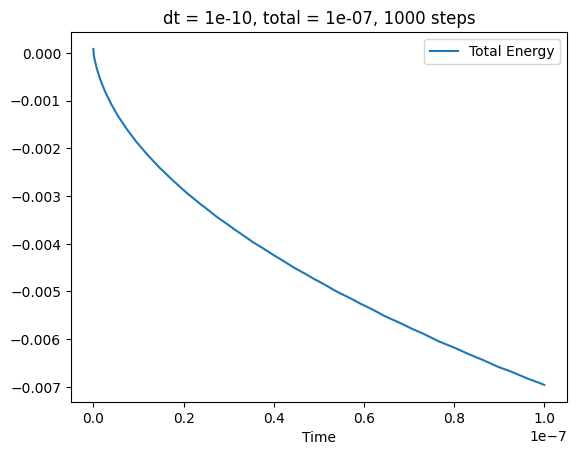

In [21]:
my_time = np.linspace(0, T_MAX_DIM, num_steps+1)

plt.plot(my_time, energy_list+kin_energy_list, label="Total Energy")
plt.xlabel("Time")
plt.title(f"dt = {time_step_dim}, total = {T_MAX_DIM}, {num_steps} steps")
plt.legend()
plt.savefig("total_energy_graph.pdf")

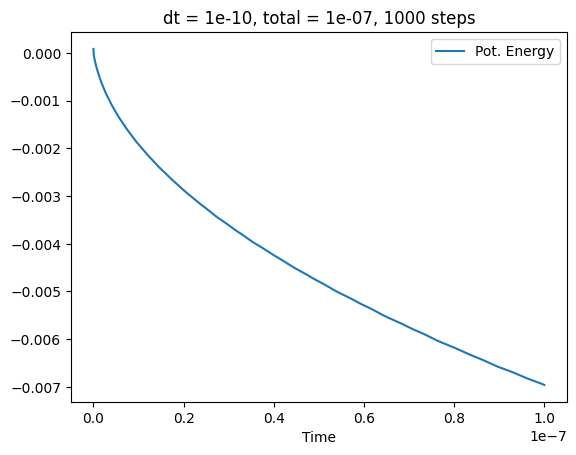

In [22]:
my_time = np.linspace(0, T_MAX_DIM, num_steps+1)

plt.plot(my_time, energy_list, label="Pot. Energy")
plt.xlabel("Time")
plt.title(f"dt = {time_step_dim}, total = {T_MAX_DIM}, {num_steps} steps")
plt.legend()
plt.savefig("potential_energy_graph.pdf")


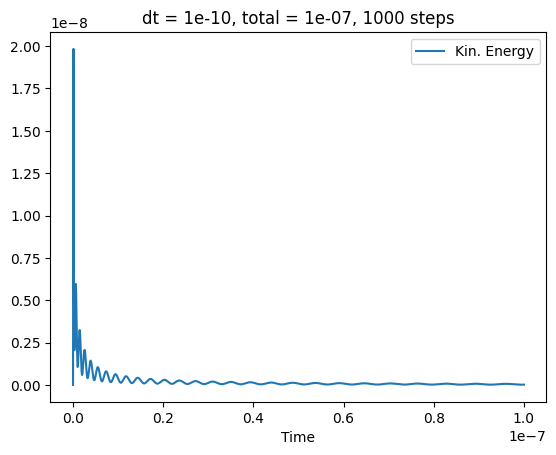

In [23]:

plt.plot(my_time, kin_energy_list, label="Kin. Energy")
plt.xlabel("Time")
plt.title(f"dt = {time_step_dim}, total = {T_MAX_DIM}, {num_steps} steps")
plt.legend()
plt.savefig("kinetic_graph.pdf")

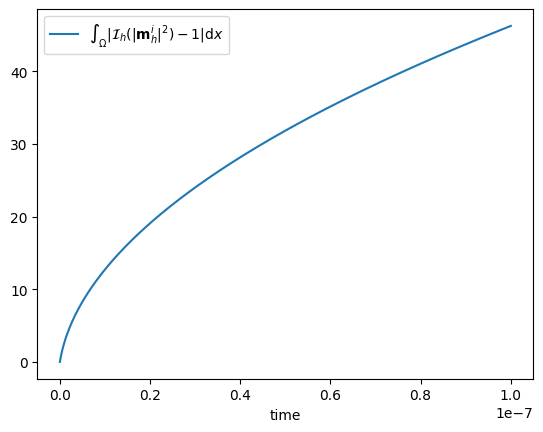

In [24]:
plt.plot(my_time, integral_list, label=r"$\int_{\Omega}|\mathcal{I}_{h}(|\mathbf{m}_{h}^{i}|^2)-1| \mathrm{d}x$")
plt.xlabel(r"time")
plt.legend()
plt.savefig("integral_graph.pdf")

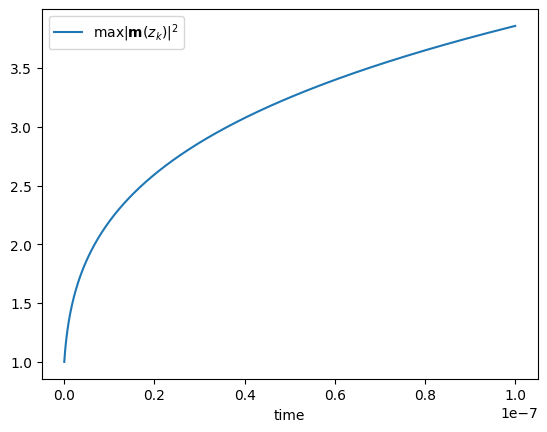

In [25]:
plt.plot(my_time, nodal_sum_list, label=r"$\max |\mathbf{m}(z_k)|^2$")
plt.xlabel(r"time")
plt.legend()
plt.savefig("nodalmax_graph.pdf")

In [26]:
totalenergy = energy_list+kin_energy_list
np.save("totalenergy", totalenergy)
np.save("potentialenergy", energy_list)
np.save("kinenergy", kin_energy_list)
np.save("integrals", integral_list)
np.save("nodal_max", nodal_sum_list)
np.save("mytimelist", my_time)
np.save("x_average", x_average_list)
np.save("y_average", y_average_list)
np.save("z_average", z_average_list)
np.save("x_average_disp", x_average_disp_list)
np.save("y_average_disp", y_average_disp_list)
np.save("z_average_disp", z_average_disp_list)

$\int_{\Omega}|\mathcal{I}_{h}(|\mathbf{m}_{h}^{N}|^2)-1| \mathrm{d}x$

In [27]:
print(f"Constraint error is {magfunc.constraint_error(fes_scalar, mag_gfu, mesh)}")

Constraint error is 46.25011255699209


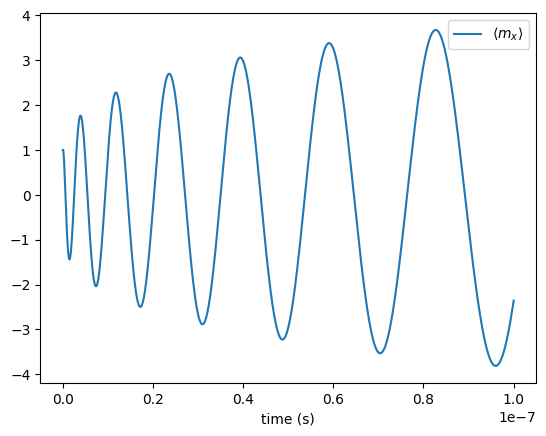

In [28]:
plt.plot(my_time, x_average_list, label=r"$\langle m_{x} \rangle$")
plt.xlabel(r"time (s)")
plt.legend()
plt.savefig("x_average_graph.pdf")

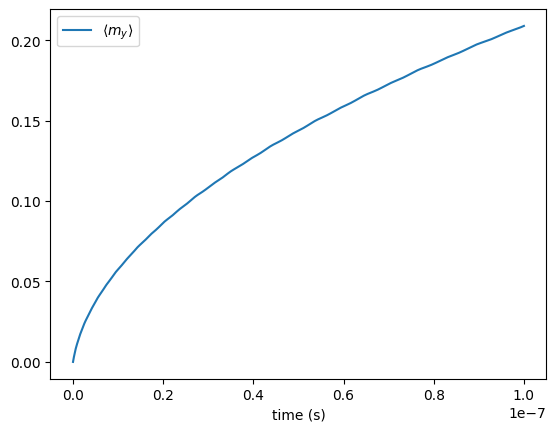

In [29]:
plt.plot(my_time, y_average_list, label=r"$\langle m_{y} \rangle$")
plt.xlabel(r"time (s)")
plt.legend()
plt.savefig("y_average_graph.pdf")

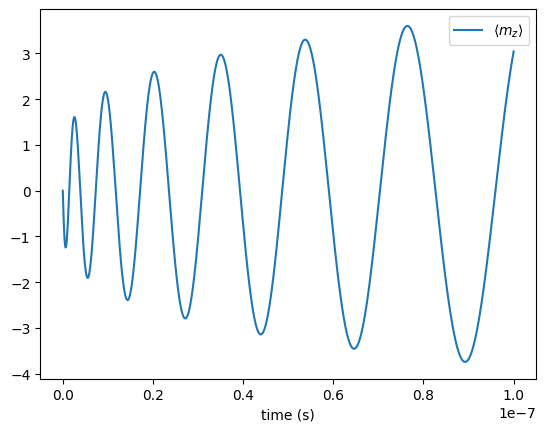

In [30]:
plt.plot(my_time, z_average_list, label=r"$\langle m_{z} \rangle$")
plt.xlabel(r"time (s)")
plt.legend()
plt.savefig("z_average_graph.pdf")